In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

In [2]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/OBAGoldenSample.fits', Rsun=Rsun, esphs=False)

Number of stars in selected sample: 19218


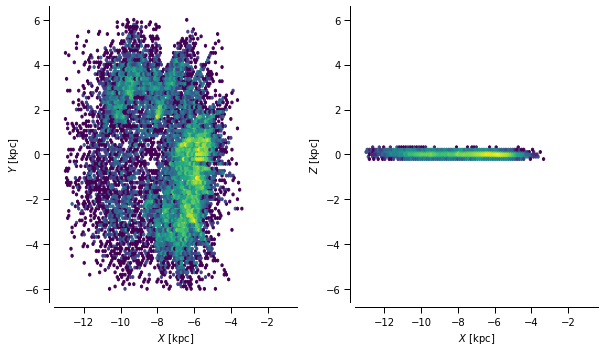

In [3]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

# Choice of stars
spt_lum_filter = giants
fit_save_location = os.path.join(os.getcwd(), 'fitfiles/giants')

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

Median d*sin(b): -22.8
RSE d*sin(b): 86.3
Mean d*sin(b): -17.2


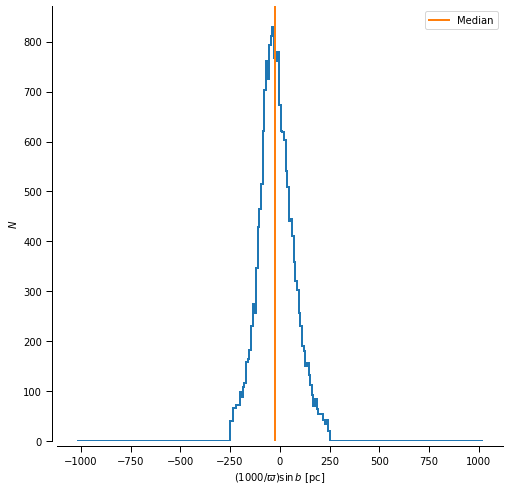

In [4]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

In [5]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun': zsun.value
            }
with open('fgkm.data.json', 'w') as fp: 
    ujson.dump(fgkm_data, fp)    # R: Converts python object to JSON data format
    fp.close()
    

base_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_1.stan',
                'npars': 7,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

improved_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_2.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', 'V_0', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'v0':234.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'v0':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_2_giants_std.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy_vector', 'vdispz'],
                'labels':[r'h', r'p', 'V_0', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'v0':234.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':np.nan, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'v0':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp2_3_model_nov0 = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_nov0.stan',
                'npars': 11,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan}
                }

vdisp_function_bp2_3_model_with_v0 = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_with_v0.stan',
                'npars': 12,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z', 'v0'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}', r'V_0'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1, 'v0':234.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan, 'v0':np.nan}
                }

stan_model = vdisp_function_bp2_3_model_nov0

Number of sources in sample: 3000


In [6]:
# Reading in earlier produced fits
filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)

fgkm_fit = from_csv(path=fit_save_location)
print(fit_save_location[-len(filter_of_choice):])

23:04:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 39 divergent transitions (3.9%)
	Chain 3 had 26 divergent transitions (2.6%)
	Use function "diagnose()" to see further information.


giants


In [16]:
print("Chains:", fgkm_fit.chains)
temp = fgkm_fit[fgkm_fit.chain_ids != 1]
print("Chain_ids:", temp)
# print("Column names:", fgkm_fit.column_names)
print("Divergences:", fgkm_fit.divergences)

# temp.summary()[0:stan_model['npars']+6]

Chains: 4


TypeError: 'CmdStanMCMC' object is not subscriptable

In [42]:
draws = fgkm_fit.draws()
print(np.size(draws))
print("# draws:", len(draws[:,0,0]))
print("# chains:", len(draws[0,:,0]))
print("# columns:", len(draws[0,0,:]))
print(np.size(draws[:,1:,:]))
# print(draws[:,1:,:])
good_draws = draws[:,1:,:]
fit_test_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice, 'test')
# numpy.savetxt("fitfiles/giants/foo.csv", good_draws, delimiter=",")
for i in range(3):
    np.savetxt(os.path.join(fit_test_location, "test_csv_{}.csv".format(i)), good_draws[:,i,:], delimiter=",")
    print(os.path.join(fit_test_location, "test_csv_{}.csv".format(i)))

96120000
# draws: 1000
# chains: 4
# columns: 24030
72090000
<class 'numpy.ndarray'>
C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\test\test_csv_0.csv
C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\test\test_csv_1.csv
C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\test\test_csv_2.csv


In [46]:
# Reading in earlier produced fits
filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice, "test")

test_fit = from_csv(path=fit_save_location)
print(fit_save_location[-len(filter_of_choice):])

ValueError: File C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\test\test_csv_0.csv is not a Stan CSV file.

In [7]:
print(fit_save_location)
fgkm_fit.summary()[0:stan_model['npars']+6]
# Made by using the 3 converged fit files.

C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-7.297940e+07,4.219990e+07,5.176190e+07,-1.145280e+08,-1.045900e+08,-5749.040000,1.50452,0.000750,1026.06000
h_param,9.066290e+02,1.045220e+03,1.282060e+03,5.957070e-03,4.098480e-01,2719.470000,1.50451,0.000750,31533.70000
p_param,7.742330e-01,5.775140e+00,7.095050e+00,-5.025940e+00,-3.286860e+00,10.739900,1.50934,0.000752,16.50110
Vsun_pec_x,1.502700e+01,2.104080e+00,2.695210e+00,1.298450e+01,1.349460e+01,20.230300,1.64083,0.000818,3.21028
Vsun_pec_y,2.994400e+01,3.482900e+00,4.287670e+00,2.311260e+01,3.285300e+01,33.065000,1.51551,0.000755,10.73430
Vsun_pec_z,4.501140e+00,3.229180e+00,3.961630e+00,-6.939170e-01,5.287660e+00,9.081740,1.50509,0.000750,47.07050
amplitude_x,3.929640e+01,4.400870e+01,5.400360e+01,1.706890e-01,2.117450e+00,119.073000,1.50580,0.000750,31.22630
amplitude_y,1.093790e+01,1.211960e+01,1.492100e+01,4.278290e-01,4.589250e-01,34.650000,1.51573,0.000755,10.81190
amplitude_z,1.020640e+01,4.963210e+00,6.092780e+00,1.672390e+00,1.351400e+01,15.429700,1.50698,0.000751,22.67210
R_scale_x,6.936790e+00,6.327860e+00,7.790940e+00,8.886300e-01,2.010220e+00,19.339900,1.51588,0.000755,10.65210


In [15]:
print(fit_save_location)
fgkm_fit.summary()[0:stan_model['npars']+6]
# Made by using all 4 fit files, including the one that hit max treedepth.

C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-6.317470e+07,4.465690e+07,6.325110e+07,-1.309450e+08,-27677.500000,-5671.100000,2.00614,0.000101,248.41600
h_param,8.781830e-01,8.845100e-01,1.254260e+00,1.020830e-02,0.263355,3.043710,2.01079,0.000101,19.28980
p_param,-1.481690e+00,6.029150e-01,9.959800e-01,-3.333830e+00,-0.726053,-0.579928,2.72891,0.000137,1.89079
Vsun_pec_x,9.008540e+00,6.687580e+00,9.664350e+00,-5.512590e-01,1.662360,21.043800,2.08837,0.000105,4.85764
Vsun_pec_y,1.156680e+01,7.915100e+00,1.126090e+01,-8.106060e-01,11.134200,23.924700,2.02411,0.000102,10.06210
Vsun_pec_z,4.771880e+00,2.905160e+00,4.117320e+00,-3.181630e-02,7.299010,9.063820,2.00857,0.000101,26.41530
amplitude_x,6.655950e+01,4.639580e+01,6.672940e+01,4.755180e-01,66.269300,136.626000,2.06860,0.000104,5.40281
amplitude_y,2.871070e+01,2.178250e+01,6.581160e+01,2.205820e-01,14.787600,54.840200,9.12831,0.000458,1.13263
amplitude_z,6.862190e+00,4.488820e+00,7.198430e+00,2.375350e-01,10.628300,13.187000,2.57165,0.000129,2.03102
R_scale_x,9.466620e+00,6.294200e+00,9.032820e+00,1.408060e-01,1.074490,20.385800,2.05952,0.000103,5.89917


In [16]:
import winsound
frequency = 1000  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

# Now small test without v0

In [53]:
# Reading in earlier produced fits
filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice, "Backup")

test_fit = from_csv(path=fit_save_location)
print(fit_save_location[-len(filter_of_choice):])

13:32:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Backup


In [54]:
# I have removed chain 4 (34.8% iterations at max treedepth).
print(fit_save_location)
test_fit.summary()[0:stan_model['npars']+6]
# Made by using the 3 converged fit files.
# Without v0

C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\Backup


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-8.423090e+07,4.864640e+07,5.967140e+07,-1.310580e+08,-1.220220e+08,-5671.720000,1.50463,0.000712,207.96400
h_param,1.137230e+00,1.100980e+00,1.351250e+00,1.579230e-02,2.728990e-01,3.043730,1.50631,0.000713,26.47650
p_param,-1.197630e+00,6.541120e-01,9.039700e-01,-3.074760e+00,-7.258570e-01,-0.578569,1.90987,0.000904,2.04620
Vsun_pec_x,5.993160e+00,7.397790e+00,9.113630e+00,-6.447780e-01,-2.884410e-01,20.701700,1.51767,0.000719,9.84227
Vsun_pec_y,7.920830e+00,8.704210e+00,1.068250e+01,-8.106280e-01,1.689490e+00,23.743100,1.50622,0.000713,27.29400
Vsun_pec_z,3.417020e+00,3.181130e+00,3.902630e+00,-3.182650e-02,1.433440e+00,9.026840,1.50506,0.000713,48.43420
amplitude_x,4.417380e+01,4.959090e+01,6.086760e+01,4.755170e-01,1.893570e+00,134.788000,1.50650,0.000713,25.40720
amplitude_y,1.656420e+01,1.741180e+01,2.153790e+01,2.194700e-01,2.837010e+00,52.194600,1.53011,0.000725,7.11683
amplitude_z,4.686440e+00,4.574880e+00,5.615690e+00,2.341500e-01,1.207290e+00,13.081800,1.50677,0.000713,23.76070
R_scale_x,6.606070e+00,6.946180e+00,8.546790e+00,1.408060e-01,1.063580e+00,20.015900,1.51396,0.000717,11.66170


In [17]:
# data Rsun
# real Vcirc_sun = Rsun/h_param * (1 + (Rsun/h_param)^2) ^ ((p_param-2)/4);
# This is only the scaling factor. What is v_0?
Rsun_float = float(Rsun/(1*u.pc)) # in pc
print(Rsun_float)
h_param = 0.14
p_param = 0.370 # in pc
# v_0 = 
vcsun_data = 234.0
Vcircsun = Rsun_float/h_param * (1 + (Rsun_float/h_param)**2) ** ((p_param-2)/4)
v0 = vcsun_data/Vcircsun
vc = v0*Vcircsun

print("Vcircsun:", Vcircsun*u.pc/(u.s))
Vcircsun_with_units = Vcircsun*u.pc/u.s
print("Vcircsun:", Vcircsun_with_units.to(u.km/u.s))
print(v0)
print(vc)

8277.0
Vcircsun: 7.6343630711626504 pc / s
Vcircsun: 235571829776521.75 km / s
30.65088702473299
234.0


In [11]:
fgkm_fit.diagnose()

"Processing csv files: C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_nov0-20230403113246_1.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_nov0-20230403113246_2.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_nov0-20230403113246_3.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_nov0-20230403113246_4.csv\n\nChecking sampler transitions treedepth.\n348 of 4000 (8.70%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.\nTrajectories that are prematurely terminated due to this limit will result in slow exploration.\nFor optimal performance, increase this limit.\n\nChecking sampler transitions for divergences.\n1 of 4000

['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z']
h_param = 0.1+6.9-0.1
p_param = -1.7+3.3-1.1
Vsun_pec_x = 19.3+2.3-21.1
Vsun_pec_y = 23.0+0.8-24.9
Vsun_pec_z = 9.0+0.2-6.9
amplitude_x = 124.1+5.9-124.0
amplitude_y = 49.0+6.6-3.5
amplitude_z = 14.2+0.8-13.8
R_scale_x = 18.2+2.0-18.1
R_scale_y = 5.3+44.6-0.6
R_scale_z = 16.4+1.9-15.8


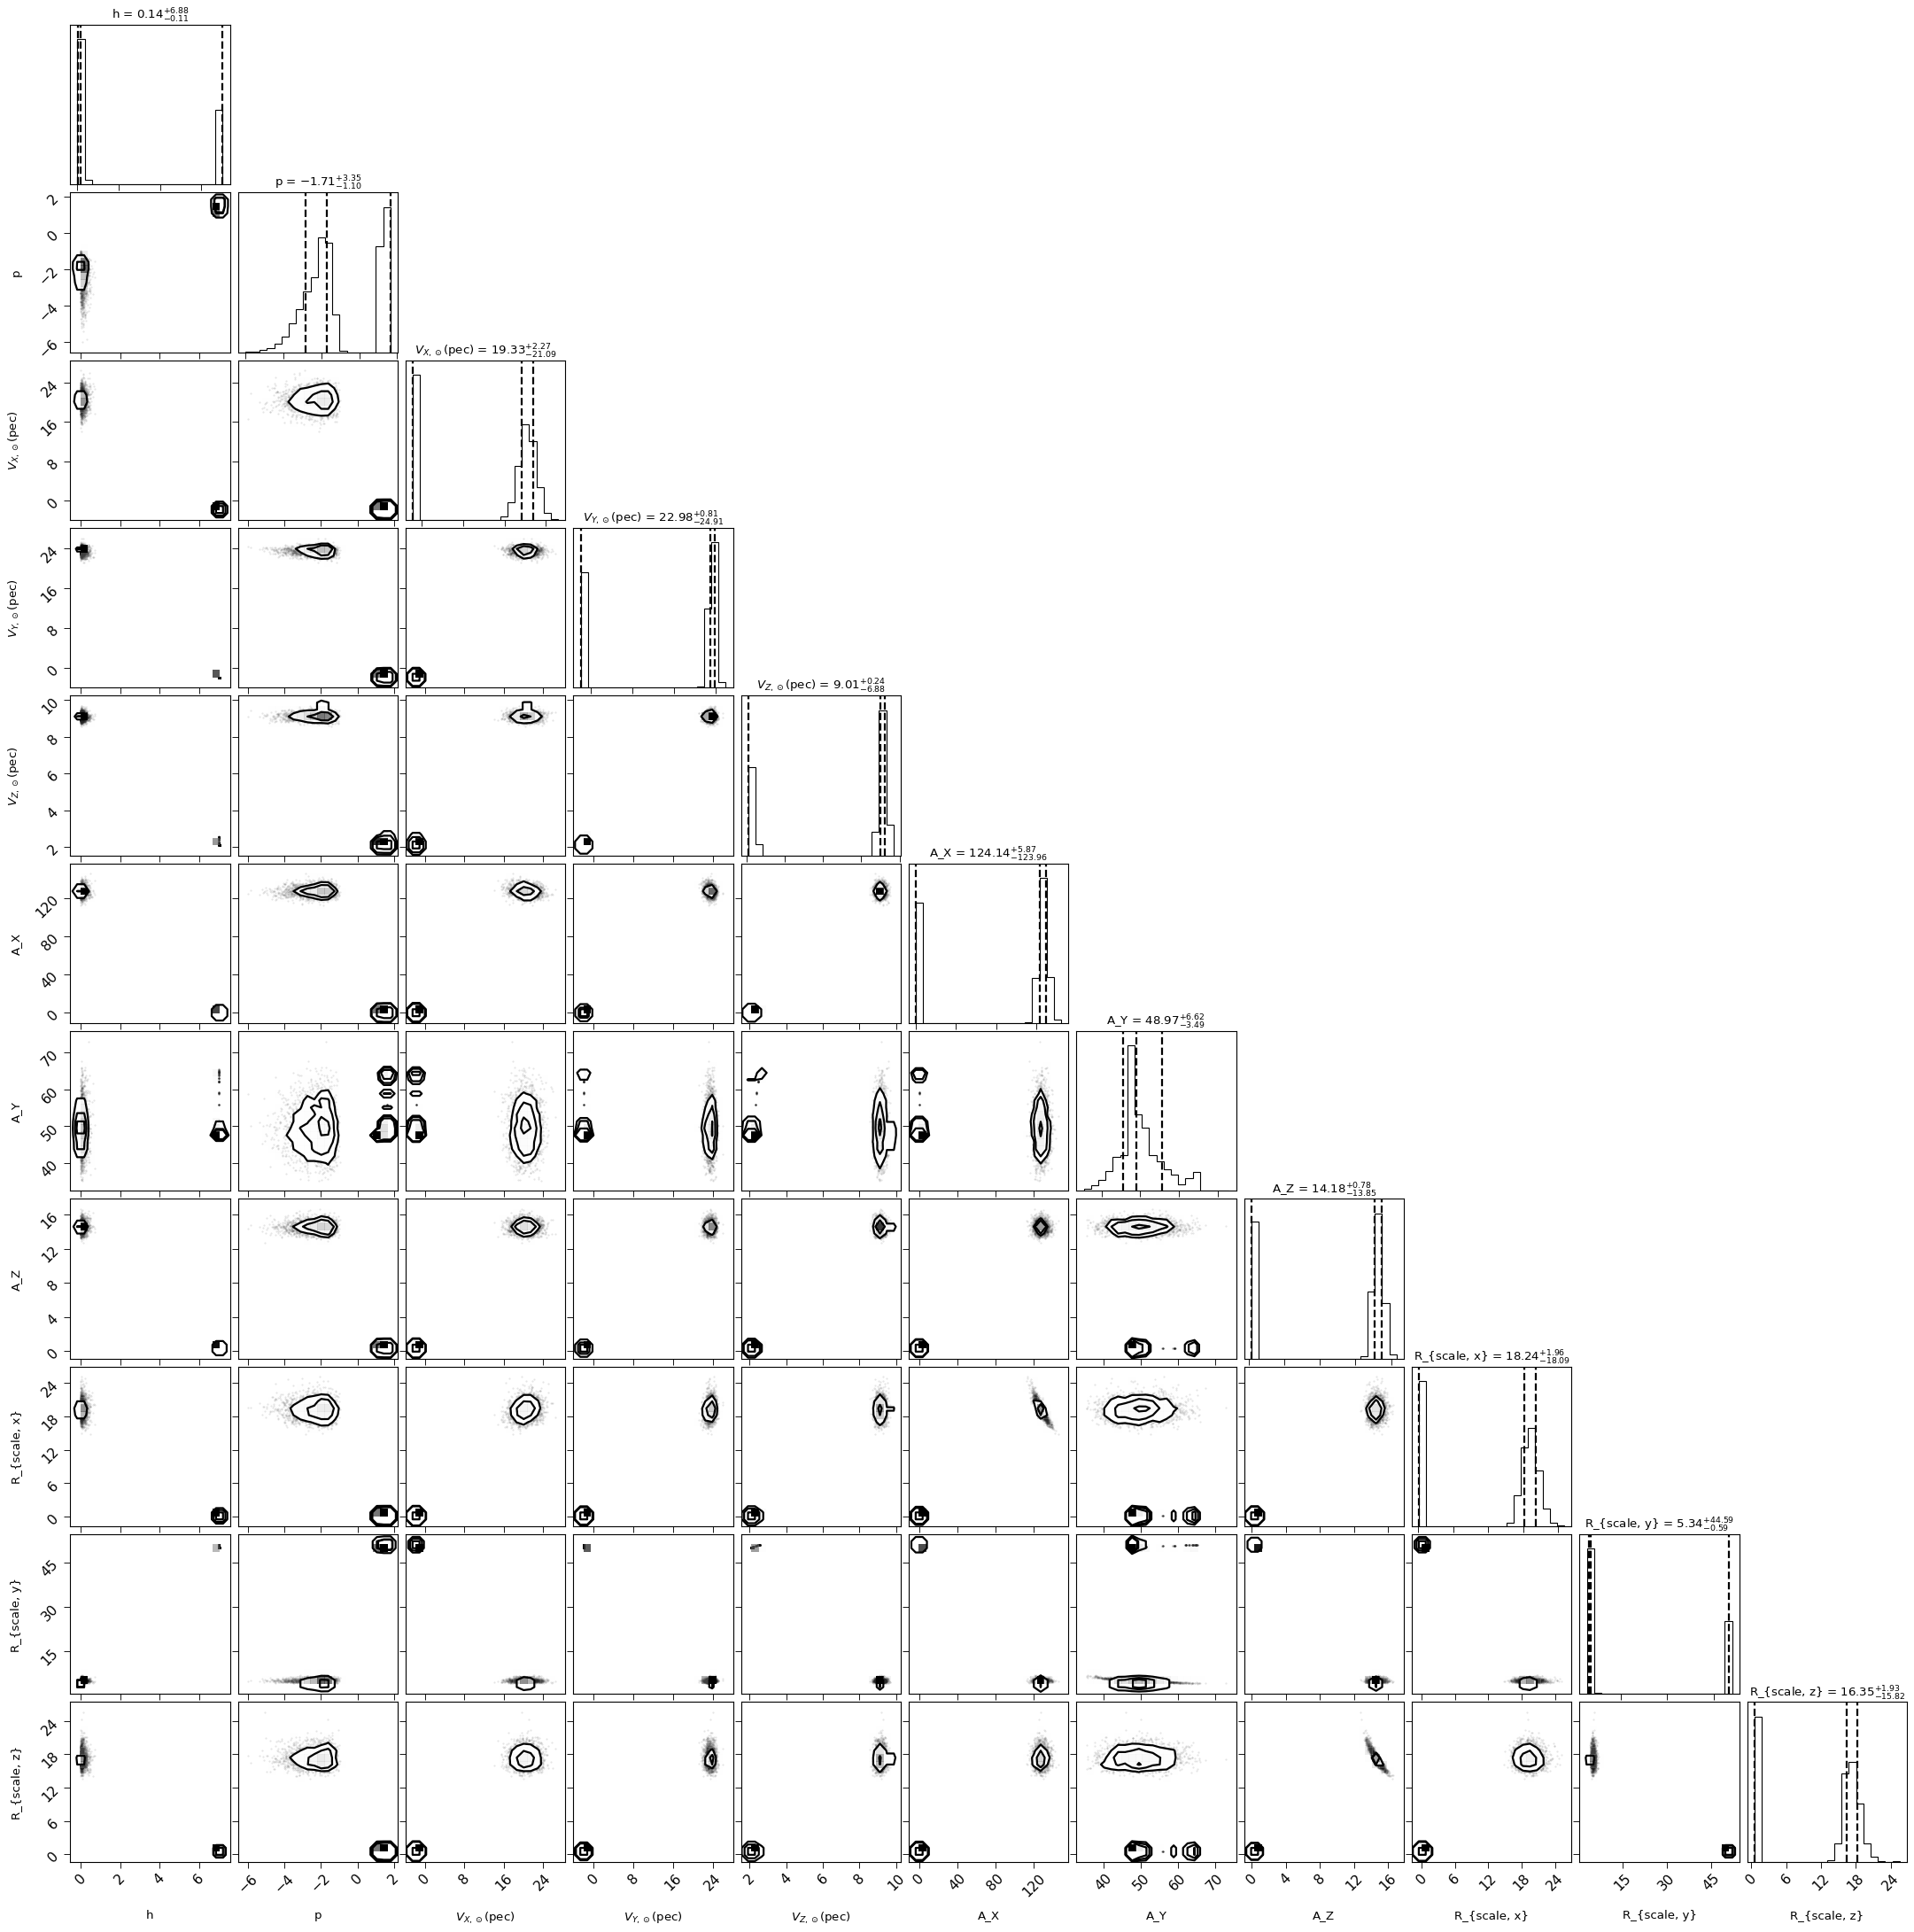

{'h_param': 0.1393325, 'p_param': -1.71083, 'Vsun_pec_x': 19.32865, 'Vsun_pec_y': 22.983249999999998, 'Vsun_pec_z': 9.00809, 'amplitude_x': 124.144, 'amplitude_y': 48.9658, 'amplitude_z': 14.1759, 'R_scale_x': 18.23955, 'R_scale_y': 5.343145, 'R_scale_z': 16.352249999999998}
11
[array([0.141089 , 7.04952  , 0.0241228, ..., 0.0725808, 7.00303  ,
       0.0493147]), array([-1.52285 ,  0.966082, -2.55496 , ..., -1.44851 ,  1.64055 ,
       -2.07593 ]), array([20.0601 , -1.76492, 20.1134 , ..., 19.3956 , -1.75336, 19.6092 ]), array([23.087  , -1.92401, 22.4021 , ..., 23.0117 , -1.92384, 23.6726 ]), array([8.87872, 2.10928, 9.1052 , ..., 8.89957, 2.5648 , 9.10016]), array([132.39    ,   0.180942, 129.383   , ..., 139.711   ,   0.180765,
       120.843   ]), array([50.9275, 46.9551, 49.4658, ..., 50.3008, 65.3359, 48.2355]), array([14.4797  ,  0.328309, 15.0121  , ..., 13.8372  ,  0.328625,
       14.5227  ]), array([18.401   ,  0.152424, 19.1088  , ..., 15.7369  ,  0.152392,
       21.4477 

In [55]:
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(7, 7+stan_model['npars']), stan_model['parnames']): # Adjusted the number from 9 to 2 (# of parameters)
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

# Number of draws is very low
print(stan_model['best_params'])
print(len(sample_lists))
print(sample_lists)
print(samples)
print(len(samples)) # 4000 samples
# Dit was gecreerd met een subsample van 10000 ipv 3000.